## Check for Programmatic variations


check which hybrid performed best do we prefer precision or recall

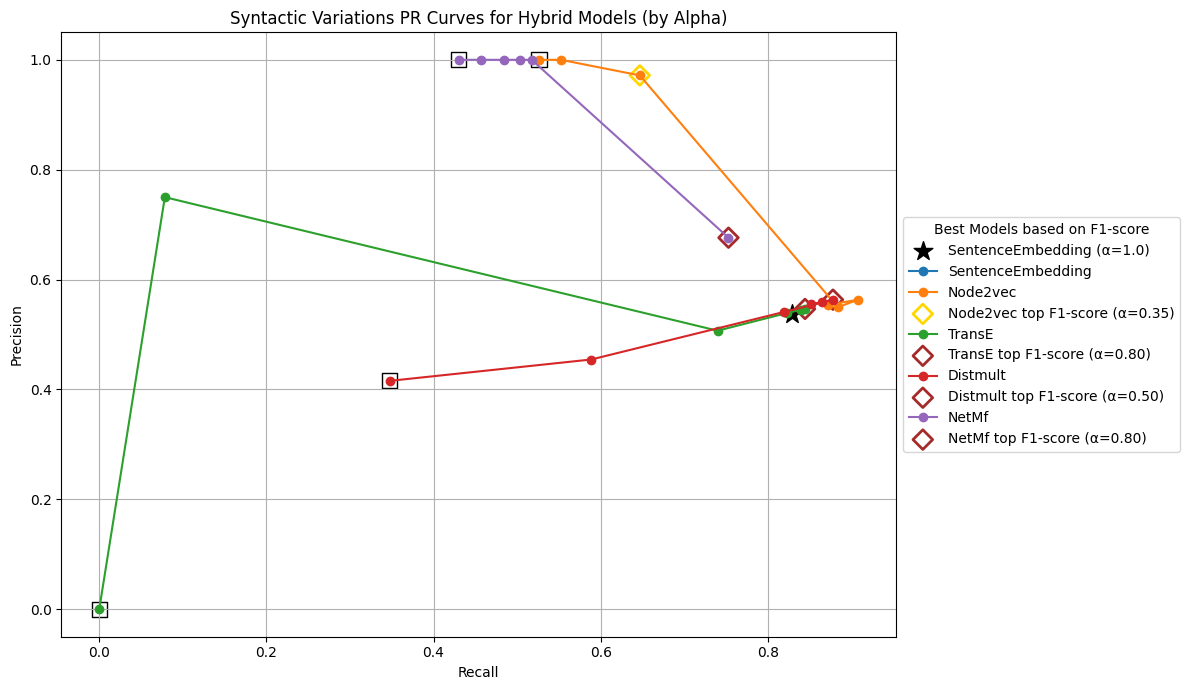

In [20]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np
noise = 'high'
# Path and file setup
match_dir = f"matches_{noise}"

golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')
model_bases = {
    'SentenceEmbedding': "SentenceEmbedding",
    'Node2vec': "HybridNode2vecLow_alpha_",
    'TransE': "HybridTransE_alpha_",
    'Distmult': "HybridDistmult_alpha_",
    'NetMf': "HybridNetMf_alpha_",
}
alpha_values = [0.0, 0.2, 0.35, 0.5, 0.65, 0.8, 1.0]

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

def evaluate_matches(match_data, golden_standard):
    identifiers = []
    true_duplicate_pairs = set()
    for match in match_data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        # Always add all pairs to identifiers
        identifiers.append(pair)
        # If this match is an exact/true duplicate, remember the pair
        if match.get('duplication_type') == 'true_duplicate':
            # Use sorted tuple to be order-agnostic
            uuid1, uuid2 = pair['entity1'], pair['entity2']
            true_duplicate_pairs.add(tuple(sorted([uuid1, uuid2])))
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )
    # Filter out 'true_duplicate' pairs from the false positives
    false_positives = (matched_pairs_set - golden_pairs_set) - true_duplicate_pairs

    TP = len([
        1 for pair in matched_pairs_set if pair in golden_pairs_set
    ])
    FP = len(false_positives)
    FN = len(golden_pairs_set - matched_pairs_set)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall

# Prepare to store results
pr_curves = {model: {'precisions': [], 'recalls': [], 'alphas': []} for model in model_bases.keys()}

for model, base in model_bases.items():
    for alpha in alpha_values:
        if alpha == 1.0:
            filename = os.path.join(match_dir, "SentenceEmbedding.json")
        else:
            filename = os.path.join(match_dir, f"{base}{alpha}.json")
        if not os.path.exists(filename):
            continue
        with open(filename, 'r') as f:
            match_data = json.load(f)
        precision, recall = evaluate_matches(match_data, golden_standard)
        pr_curves[model]['precisions'].append(precision)
        pr_curves[model]['recalls'].append(recall)
        pr_curves[model]['alphas'].append(alpha)

# Find the best model and alpha (highest F1 among all models and alphas except alpha=1.0)
best_model = None
best_alpha = None
best_f1 = -1
best_idx = None

for model, curve in pr_curves.items():
    for i, (p, r, a) in enumerate(zip(curve['precisions'], curve['recalls'], curve['alphas'])):
        if a == 1.0:
            continue  # skip SentenceEmbedding
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_alpha = a
            best_idx = i

plt.figure(figsize=(12, 7))

# Plot SentenceEmbedding (alpha=1.0) only once
if 'SentenceEmbedding.json' in [os.path.basename(os.path.join(match_dir, "SentenceEmbedding.json"))]:
    se_precision, se_recall = None, None
    for model, curve in pr_curves.items():
        for i, alpha in enumerate(curve['alphas']):
            if alpha == 1.0:
                se_precision = curve['precisions'][i]
                se_recall = curve['recalls'][i]
                break
    if se_precision is not None and se_recall is not None:
        plt.scatter(se_recall, se_precision, marker='*', s=200, color='black', label='SentenceEmbedding (α=1.0)')

# Plot each model's PR curve, highlight best hybrid, and highlight alpha=0.0
for model, curve in pr_curves.items():
    hybrid_recalls = [r for a, r in zip(curve['alphas'], curve['recalls']) if a != 1.0]
    hybrid_precisions = [p for a, p in zip(curve['alphas'], curve['precisions']) if a != 1.0]
    hybrid_alphas = [a for a in curve['alphas'] if a != 1.0]
    plt.plot(hybrid_recalls, hybrid_precisions, marker='o', label=model)
    # Highlight starting point (alpha=0.0)
    if 0.0 in curve['alphas']:
        idx0 = curve['alphas'].index(0.0)
        plt.scatter(curve['recalls'][idx0], curve['precisions'][idx0], marker='s', s=120, color='none', edgecolor='black')
    # Find best hybrid (highest F1)
    best_idx_model = None
    best_f1_model = -1
    for i, (p, r) in enumerate(zip(hybrid_precisions, hybrid_recalls)):
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1_model:
            best_f1_model = f1
            best_idx_model = i
    if best_idx_model is not None:
        marker_color = 'gold' if model == best_model else 'brown'
        plt.scatter(hybrid_recalls[best_idx_model], hybrid_precisions[best_idx_model], marker='D', s=100, edgecolor=marker_color, facecolor='none', linewidths=2, label=f"{model} top F1-score (α={hybrid_alphas[best_idx_model]:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Syntactic Variations PR Curves for Hybrid Models (by Alpha)')
plt.legend(
    loc='center left',       # place legend to the right
    bbox_to_anchor=(1, 0.5), # shift legend outside plot
    title='Best Models based on F1-score',  # legend header title
    frameon=True
)
plt.grid(True)
plt.tight_layout()
plt.show()

Use the Best hybrid and compare the methods to one another


Number of missing golden_standard pairs: 118


,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value
65,ea5fe267-5877-4d3a-a8b5-a07a9659a673,49e76b10-eba7-4884-97df-e6d6bceb6d96,Address,country_expansion,country,AT,Austria
105,92d6ff73-5b3a-4595-8458-92c14e0e15d3,4d8244da-3e6f-4a18-9d76-d9ba4272fcff,HealthcareOrganization,name_abbreviation,healthcareOrganizationName,"Delgado, Guerrero and Simpson Zorg",DGS Zorg
116,bf7b6b3c-b1ca-41c3-8061-d029cb1d6d78,fd85d57d-1847-4560-90b7-8c153c43f9dd,ServiceDepartment,department_typo,serviceDepartmentName,Geriatric,Geiatric
119,de9ac8b8-640b-4b28-8322-b4ff856df911,fc62388a-1bad-4a19-92c1-8e81c7351050,ServiceDepartment,translation,serviceDepartmentName,Renal,Nieren
126,6689ef79-f8c3-4461-bc15-b016487eb3df,a56e3fcc-d5c5-4f3a-8e10-a9dea407e939,ServiceDepartment,department_typo,serviceDepartmentName,Pediatric,Pldiatric
...,...,...,...,...,...,...,...
911,b0ca76f7-17f9-4524-8332-ed33bba6e752,bc0e7311-0f1b-4d24-acb9-ca7b91ba5b96,ContactPoint,translation,contactType,referrals,suunamine
915,84ddf869-b816-4f1a-9677-013ba8e19b83,1d3976f9-6b44-49dc-ae74-13f04b65e378,ContactPoint,translation,contactType,emergency,hÃ¤daolukord
923,fae3fcee-7636-4fd9-8376-ffa876fe579f,644064d5-1f21-49b4-8748-66303f5b02e8,ContactPoint,email_typo,email,PerezBecker@healthcare.org,PerzeBecker@healthcare.org
925,6efeb18f-aaa6-4ef9-bbb6-ba4c140ab78e,0a671326-68dd-4e6f-ac93-fd83642e2475,ContactPoint,translation,contactType,staff,personeel



Precision/Recall/F1 per entity type for SentenceEmbedding:
                        Precision  Recall      F1
Address                    1.0000  0.9902  0.9951
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2731  0.6889  0.3912
Person                     1.0000  0.8228  0.9028
HealthcarePersonnel        1.0000  0.8481  0.9178
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for TransE 0.8:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2888  0.7444  0.4161
Person                     1.0000  0.8323  0.9085
HealthcarePersonnel        1.0000  0.8639  0.9270
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for Distmult 0.5:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.500

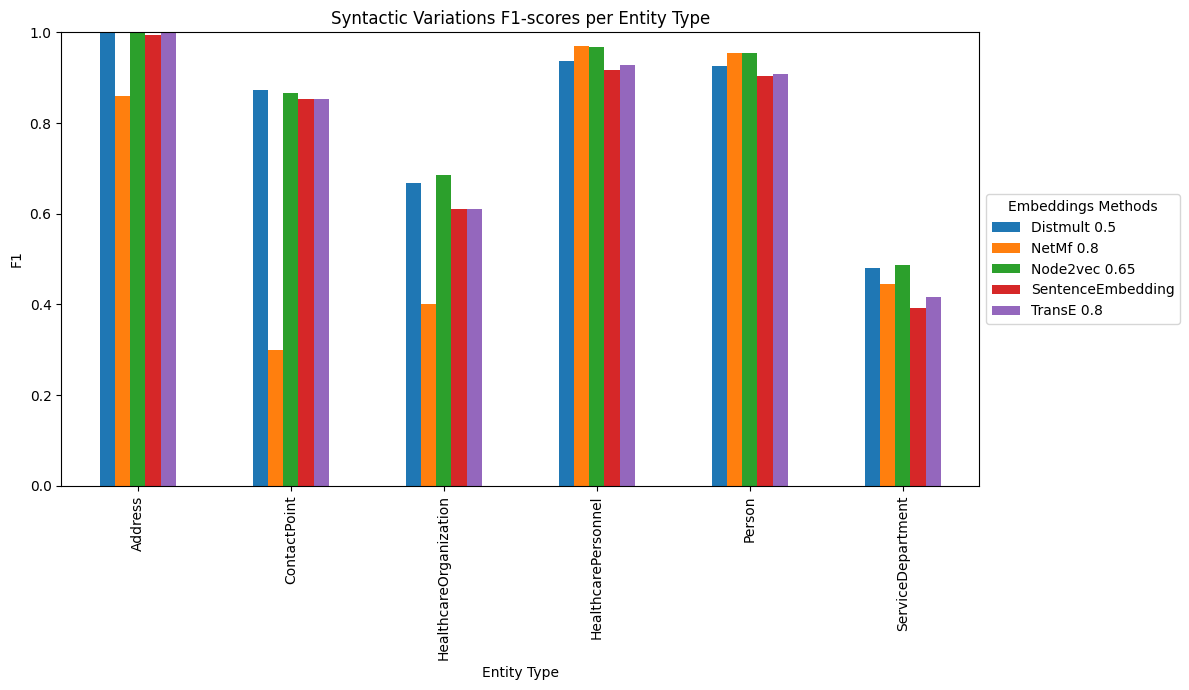

In [21]:
noise = 'high'
golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')

# Define which match files to analyze
match_files = {
    'SentenceEmbedding': f'matches_{noise}/SentenceEmbedding.json',
    'TransE 0.8' : f'matches_{noise}/HybridTransE_alpha_0.8.json',
    'Distmult 0.5': f'matches_{noise}/HybridDistmult_alpha_0.5.json',
    'NetMf 0.8' : f'matches_{noise}/HybridNetMf_alpha_0.8.json',
    'Node2vec 0.65': f'matches_{noise}/HybridNode2vecLow_alpha_0.65.json',
}


entity_type_pr_summary = {}

for match_type, filepath in match_files.items():
    with open(filepath, 'r') as f:
        data = json.load(f)

    # --- Extract all predicted pairs and true_duplicate pairs once ---
    all_pairs = []
    all_pair_to_type = {}
    true_dup_pairs = set()

    for match in data:
        entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
        entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
        uuid1, uuid2 = extract_uuid(entity1.get("subject")), extract_uuid(entity2.get("subject"))
        pair = tuple(sorted([uuid1, uuid2]))
        all_pairs.append(pair)
        # Try to infer entity_type (from entity1 or entity2) if possible, or skip
        # (Here, you should store all types involved for later filtering)
        all_pair_to_type[pair] = None  # will filter per entity_type later
        if match.get("duplication_type") in ['true_duplicate', 'exact']:
            true_dup_pairs.add(pair)

    all_pairs_set = set(all_pairs)

    # -- Per-entity-type PRF calculation --
    prf_per_entity = {}
    entity_types = golden_standard['entity_type'].unique()

    for entity_type in entity_types:
        # Filter golden standard for this entity type
        gold_type_df = golden_standard[golden_standard['entity_type'] == entity_type]
        gold_type_pairs = set(tuple(sorted([row['original_id'], row['duplicate_id']]))
                              for _, row in gold_type_df.iterrows())
        valid_ids = set(gold_type_df['original_id']).union(set(gold_type_df['duplicate_id']))

        # Predicted pairs where both entities are of the current type
        pred_type_pairs = set(pair for pair in all_pairs_set if pair[0] in valid_ids and pair[1] in valid_ids)

        # Exclude "exact"/"true_duplicate" predictions not in golden for this entity type
        exact_not_in_golden = len([pair for pair in pred_type_pairs - gold_type_pairs if pair in true_dup_pairs])

        TP = len(pred_type_pairs & gold_type_pairs)
        FP = len(pred_type_pairs - gold_type_pairs) #- exact_not_in_golden
        FN = len(gold_type_pairs - pred_type_pairs)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        prf_per_entity[entity_type] = {'Precision': precision, 'Recall': recall, 'F1': F1}

    entity_type_pr_summary[match_type] = prf_per_entity

# -- To DataFrames and Display --
entity_prf_dfs = {method: pd.DataFrame(prf).T.round(4) for method, prf in entity_type_pr_summary.items()}

for method, df in entity_prf_dfs.items():
    print(f"\nPrecision/Recall/F1 per entity type for {method}:")
    print(df)

combined = []
for method, df in entity_prf_dfs.items():
    df = df.copy()
    df['Method'] = method
    combined.append(df)
combined_df = pd.concat(combined).reset_index().rename(columns={'index':'Entity Type'})
combined_df = combined_df[['Method','Entity Type','Precision','Recall','F1']]
# print("\nCombined Precision/Recall/F1 per entity type:")
# print(combined_df)

# Plot Recall (change 'Recall' to 'F1' for F1 plot)
pivot_table = combined_df.pivot(index='Entity Type', columns='Method', values='F1')
pivot_table.plot(kind='bar', figsize=(12,7))
plt.title('Syntactic Variations F1-scores per Entity Type')
plt.ylabel('F1')
plt.ylim(0,1)
plt.legend(
    loc='center left',       # place legend to the right
    bbox_to_anchor=(1, 0.5), # shift legend outside plot
    title='Embeddings Methods',  # legend header title
    frameon=True
)
plt.tight_layout()
plt.show()


=== Sent_upgraded ===
Predicted pairs: 1200
True Duplicates Predicted: 147
True Positives: 570
False Positives: 489
False Negatives: 118
Precision: 0.5382
Recall: 0.8285
F1 Score: 0.6525

=== TransE 0.8 ===
Predicted pairs: 1207
True Duplicates Predicted: 150
True Positives: 581
False Positives: 482
False Negatives: 107
Precision: 0.5466
Recall: 0.8445
F1 Score: 0.6636

=== Distmult 0.5 ===
Predicted pairs: 1222
True Duplicates Predicted: 155
True Positives: 604
False Positives: 468
False Negatives: 84
Precision: 0.5634
Recall: 0.8779
F1 Score: 0.6864

=== NetMf 0.8 ===
Predicted pairs: 842
True Duplicates Predicted: 78
True Positives: 518
False Positives: 248
False Negatives: 170
Precision: 0.6762
Recall: 0.7529
F1 Score: 0.7125

=== Node2vec 0.65 ===
Predicted pairs: 1240
True Duplicates Predicted: 137
True Positives: 625
False Positives: 484
False Negatives: 63
Precision: 0.5636
Recall: 0.9084
F1 Score: 0.6956


Precision, Recall, F1 Score per Method:
               Precision  Recal

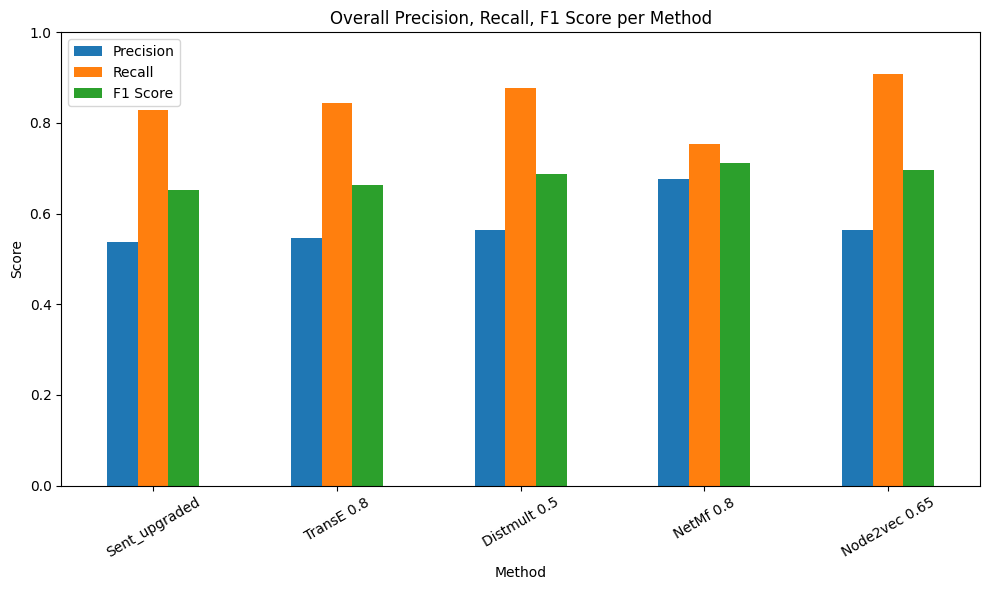

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt

noise = 'high'
golden_standard = pd.read_csv(f'data/test_golden_standard_{noise}.csv')

# Define which match files to analyze
match_files = {
    'Sent_upgraded': f'matches_{noise}/SentenceEmbedding.json',
    'TransE 0.8' : f'matches_{noise}/HybridTransE_alpha_0.8.json',
    'Distmult 0.5': f'matches_{noise}/HybridDistmult_alpha_0.5.json',
    'NetMf 0.8' : f'matches_{noise}/HybridNetMf_alpha_0.8.json',
    'Node2vec 0.65': f'matches_{noise}/HybridNode2vecLow_alpha_0.65.json',
}

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

precision_recall_summary = {}
percent_summary = {}

for match_type, filepath in match_files.items():
    with open(filepath, 'r') as f:
        data = json.load(f)

    # --- Collect all predicted pairs & label exact matches in one pass ---
    pair_tuples = []
    true_dup_pairs = set()
    for match in data:
        entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
        entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
        uuid1, uuid2 = extract_uuid(entity1.get("subject")), extract_uuid(entity2.get("subject"))
        pair = tuple(sorted([uuid1, uuid2]))
        pair_tuples.append(pair)
        if match.get("duplication_type") == "true_duplicate":
            true_dup_pairs.add(pair)

    matched_pairs_set = set(pair_tuples)
    golden_pairs_set = set(
        tuple(sorted([row['original_id'], row['duplicate_id']]))
        for _, row in golden_standard.iterrows()
    )

    # -- Metrics: TP, FP (excluding true_duplicate not in golden), FN --
    TP = len(matched_pairs_set & golden_pairs_set)
    # Exclude predicted "exact/true_duplicate" pairs that are not in the golden set from FP
    FP = len((matched_pairs_set - golden_pairs_set) - true_dup_pairs)
    FN = len(golden_pairs_set - matched_pairs_set)

    predicted_not_in_golden = matched_pairs_set - golden_pairs_set
    true_duplicates_predicted = true_dup_pairs
    # Save in a summary dict for later
    if 'analysis' not in locals():
        analysis = {}
    analysis[match_type] = {
        'predicted_not_in_golden': list(predicted_not_in_golden),
        'true_duplicates_predicted': list(true_duplicates_predicted)}

    # # Optionally, also save to file for inspection
    # with open(f"{match_type}_predicted_not_in_golden.json", "w") as f:
    #     json.dump(list(predicted_not_in_golden), f)
    # with open(f"{match_type}_true_duplicates_predicted.json", "w") as f:
    #     json.dump(list(true_duplicates_predicted), f)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"=== {match_type} ===")
    print(f"Predicted pairs: {len(pair_tuples)}")
    print(f"True Duplicates Predicted: {sum(1 for match in data if match.get('duplication_type') == 'true_duplicate')}")
    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {F1_score:.4f}\n")

    precision_recall_summary[match_type] = {'Precision': precision, 'Recall': recall, 'F1 Score': F1_score}

    # --- Analysis by variation/entity type: use golden_standard, mark which pairs matched ---
    golden_standard['pair_key'] = golden_standard.apply(
        lambda row: tuple(sorted([row['original_id'], row['duplicate_id']])), axis=1)
    golden_standard['matched'] = golden_standard['pair_key'].isin(matched_pairs_set)

    # Variation-type analysis
    variation_stats = golden_standard.groupby('variation_type').agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    variation_stats['Matched (%)'] = variation_stats['Matched_Count'] / variation_stats['Golden_Standard_Count'] * 100

    # Entity-type analysis
    entity_stats = golden_standard.groupby('entity_type').agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    entity_stats['Matched (%)'] = entity_stats['Matched_Count'] / entity_stats['Golden_Standard_Count'] * 100

    # Combined variation/entity-type analysis
    combo_stats = golden_standard.groupby(['variation_type', 'entity_type']).agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    combo_stats['Matched (%)'] = combo_stats['Matched_Count'] / combo_stats['Golden_Standard_Count'] * 100
    combo_stats = combo_stats.reset_index().sort_values(['variation_type', 'entity_type'])

    # Save for plotting
    percent_summary[match_type] = entity_stats['Matched (%)']

    # (Optional: print for debugging)
    # print(variation_stats)
    # print(entity_stats)
    # print(combo_stats)

# --- Final Reporting and Plotting ---
pr_df = pd.DataFrame(precision_recall_summary).T.round(4)
print("\nPrecision, Recall, F1 Score per Method:")
print(pr_df)

# Barplot: Percentage of matched duplicates by entity type
pr_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Method')
plt.ylabel('Score')
plt.title('Overall Precision, Recall, F1 Score per Method')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



Precision/Recall/F1 per entity type for Sent_upgraded:
                        Precision  Recall      F1
Address                    1.0000  0.9902  0.9951
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2731  0.6889  0.3912
Person                     1.0000  0.8228  0.9028
HealthcarePersonnel        1.0000  0.8481  0.9178
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for TransE.8:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.4583  0.9167  0.6111
ServiceDepartment          0.2888  0.7444  0.4161
Person                     1.0000  0.8323  0.9085
HealthcarePersonnel        1.0000  0.8639  0.9270
ContactPoint               1.0000  0.7451  0.8539

Precision/Recall/F1 per entity type for Distmult.5:
                        Precision  Recall      F1
Address                    1.0000  1.0000  1.0000
HealthcareOrganization     0.5000  1.000

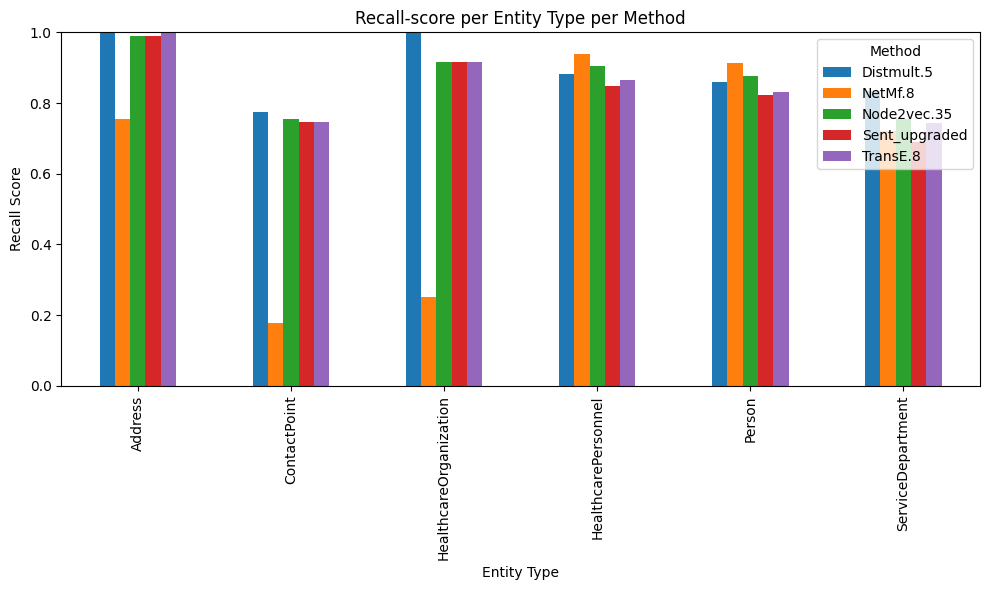

In [28]:
import pandas as pd
import json
import matplotlib.pyplot as plt

def extract_uuid(uri):
    return uri.split("/")[-1]

precision_recall_summary = {}
percent_summary = {}
entity_type_pr_summary = {}

for match_type, data in match_files.items():
    identifiers = []
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # === PER-ENTITY TYPE PRF computation ===
    prf_per_entity = {}

    # List of entity types in the golden standard
    entity_types = golden_standard['entity_type'].unique()
    # ...existing code...
    for entity_type in entity_types:
        # Filter golden pairs for this entity type
        golden_type_df = golden_standard[golden_standard['entity_type'] == entity_type]
        golden_pairs_set = set(
            (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
            for _, row in golden_type_df.iterrows()
        )
        valid_ids = set(golden_type_df['original_id']).union(set(golden_type_df['duplicate_id']))
        found_pairs_set = set(
            (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
            for pair in identifiers
            if pair['entity1'] in valid_ids and pair['entity2'] in valid_ids
        )

        # Find "exact" matches not in golden for this entity type
        exact_not_in_golden = 0
        for match in data:
            # Only consider matches for this entity type
            # (Assumes you have entity_type info in your match or can infer it)
            entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
            entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
            uuid1 = extract_uuid(entity1.get("subject"))
            uuid2 = extract_uuid(entity2.get("subject"))
            pair = (uuid1, uuid2) if uuid1 <= uuid2 else (uuid2, uuid1)
            if uuid1 in valid_ids and uuid2 in valid_ids:
                if pair not in golden_pairs_set and match.get("duplication_type") == "true_duplicate":
                    exact_not_in_golden += 1

        TP = len(golden_pairs_set & found_pairs_set)
        FP = len(found_pairs_set - golden_pairs_set) - exact_not_in_golden
        FN = len(golden_pairs_set - found_pairs_set)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        prf_per_entity[entity_type] = {'Precision': precision, 'Recall': recall, 'F1': F1}
        entity_type_pr_summary[match_type] = prf_per_entity

# Convert results to DataFrames for nice display
entity_prf_dfs = {}
for method, prf_dict in entity_type_pr_summary.items():
    df = pd.DataFrame(prf_dict).T  # entity_type as index
    entity_prf_dfs[method] = df.round(4)

# Display all PRF tables for each method
for method, df in entity_prf_dfs.items():
    print(f"\nPrecision/Recall/F1 per entity type for {method}:")
    print(df)

# If you want a combined table:
combined = []
for method, df in entity_prf_dfs.items():
    df = df.copy()
    df['Method'] = method
    combined.append(df)
combined_df = pd.concat(combined).reset_index().rename(columns={'index':'Entity Type'})
combined_df = combined_df[['Method','Entity Type','Precision','Recall','F1']]


# You can also plot per-entity F1 for all methods
f1_table = combined_df.pivot(index='Entity Type', columns='Method', values='Recall')
f1_table.plot(kind='bar', figsize=(10,6))
plt.title('Recall-score per Entity Type per Method')
plt.ylabel('Recall Score')
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
import json

# --- 1. Load golden standard and build id -> entity_type mapping ---
golden_standard = pd.read_csv('data/test_golden_standard_high.csv')
id_to_type = {}
for _, row in golden_standard.iterrows():
    id_to_type[row['original_id']] = row['entity_type']
    id_to_type[row['duplicate_id']] = row['entity_type']
all_golden_ids = set(id_to_type.keys())

# --- 2. Load predicted pairs (not in golden) ---
with open('error_analysis/Node2vec.8_predicted_not_in_golden.json', 'r') as f:
    pairs = json.load(f)

# --- 3. Check first identifier of each pair and collect entity type if matched ---
match_info = []
for pair in pairs:
    first_id = pair[0]
    if first_id in id_to_type:
        match_info.append({'id': first_id, 'entity_type': id_to_type[first_id], 'pair': pair})

# --- 4. Make a DataFrame and print entity type counts ---
df = pd.DataFrame(match_info)
print("Matched first identifiers by entity type:\n")
if not df.empty:
    print(df['entity_type'].value_counts())
    print("\nSample matches:\n", df.head())
else:
    print("No matches found for the given pairs.")


Matched first identifiers by entity type:

entity_type
ServiceDepartment         259
HealthcareOrganization     31
Name: count, dtype: int64

Sample matches:
                                      id             entity_type  \
0  09463e6f-3215-400e-a272-e2af92126ff1       ServiceDepartment   
1  76be8a0e-ed64-4bd1-a1b6-29a8fadd6ac1       ServiceDepartment   
2  7766f556-ce51-4ffc-943d-da2a7bacbd85       ServiceDepartment   
3  02246f10-ce65-4211-a3c9-c8d76ceb1865       ServiceDepartment   
4  5b87eb29-8f62-440c-a417-f1a31ec32201  HealthcareOrganization   

                                                pair  
0  [09463e6f-3215-400e-a272-e2af92126ff1, 46a6c03...  
1  [76be8a0e-ed64-4bd1-a1b6-29a8fadd6ac1, 798246e...  
2  [7766f556-ce51-4ffc-943d-da2a7bacbd85, e52bd55...  
3  [02246f10-ce65-4211-a3c9-c8d76ceb1865, 9711c99...  
4  [5b87eb29-8f62-440c-a417-f1a31ec32201, da98da5...  


In [76]:
def get_missing_rows(match_data, golden_standard):
    # Extract predicted pairs
    pair_tuples = [
        tuple(sorted([
            next(e['entity1'] for e in match['entities'] if 'entity1' in e)['subject'].split('/')[-1],
            next(e['entity2'] for e in match['entities'] if 'entity2' in e)['subject'].split('/')[-1]
        ]))
        for match in match_data
    ]
    predicted_pairs_set = set(pair_tuples)
    golden_pairs_set = set(
        tuple(sorted([row['original_id'], row['duplicate_id']]))
        for _, row in golden_standard.iterrows()
    )
    missing_pairs = golden_pairs_set - predicted_pairs_set
    missing_rows = golden_standard[
        golden_standard.apply(
            lambda row: tuple(sorted([row['original_id'], row['duplicate_id']])) in missing_pairs,
            axis=1
        )
    ]
    return missing_rows


match_files = {
    'Sent_upgraded': f'matches_{noise}/SentenceEmbedding.json',
    'Distmult 0.5': f'matches_{noise}/HybridDistmult_alpha_0.5.json',
    'Node2vec 0.35' : f'matches_{noise}/HybridNetMf_alpha_0.8.json',
    'Node2vec 0.65': f'matches_{noise}/HybridNode2vecLow_alpha_0.65.json',
}


# Example usage for all models:
missing_rows_by_model = {}
for model_name, match_file in match_files.items():
    with open(match_file, 'r') as f:
        match_data = json.load(f)
    missing_rows_by_model[model_name] = get_missing_rows(match_data, golden_standard)

# Convert each model's missed matches into a set of tuples
missed_pairs_sets = []
for model_name, df in missing_rows_by_model.items():
    model_pairs = set(
        tuple(sorted([row['original_id'], row['duplicate_id']]))
        for _, row in df.iterrows()
    )
    missed_pairs_sets.append(model_pairs)

# Intersection of all missed sets
common_missed_pairs = set.intersection(*missed_pairs_sets) if missed_pairs_sets else set()

# Get actual rows from golden_standard
common_missed_rows = golden_standard[
    golden_standard.apply(
        lambda row: tuple(sorted([row['original_id'], row['duplicate_id']])) in common_missed_pairs,
        axis=1
    )
]

print(f"Number of common missed matches: {len(common_missed_rows)}")
print(common_missed_rows)

common_missed_rows.to_csv('common_missed_matches.csv', index=False)

Number of common missed matches: 68
                              original_id  \
134  3a94f14b-0830-4ee6-9a9c-1d73f173d2fe   
144  350b62e7-9712-41a9-aecb-26826fe47e69   
160  4c407098-5dd6-4593-b1f2-c908e38dbb7e   
179  711f02ac-e905-4731-bd38-7e53f882006a   
233  7236c9fd-cfd3-4fcf-9720-e54564ddeda8   
..                                    ...   
908  da47b8f9-cee4-4404-9648-1f4b0c747a90   
910  799c82ee-f742-453b-a7a1-28de18310104   
911  b0ca76f7-17f9-4524-8332-ed33bba6e752   
915  84ddf869-b816-4f1a-9677-013ba8e19b83   
925  6efeb18f-aaa6-4ef9-bbb6-ba4c140ab78e   

                             duplicate_id        entity_type  \
134  b0563e9c-5b52-472d-bcc5-6d2fead82159  ServiceDepartment   
144  b1b1999a-b811-4ad4-97da-0a67ad686c26  ServiceDepartment   
160  ba16f676-d7aa-439b-93b0-5344313bfba0  ServiceDepartment   
179  e95abddc-de46-4865-b92a-939d655b8ce9  ServiceDepartment   
233  1d78e1f3-0809-489d-a61a-06bb2d65a8f0             Person   
..                                    .

In [74]:
common_missed_rows = common_missed_rows.reset_index(drop=True)
common_missed_rows
# # Plot missed counts per variation_type
# missed_counts = common_missed_rows['variation_type'].value_counts().sort_index()
# plt.figure(figsize=(10,6))
# missed_counts.plot(kind='bar', color='salmon')
# plt.ylabel('Number of Missed Matches')
# plt.xlabel('Variation Type')
# plt.title('Missed Matches per Variation Type (Common Missed)')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value
0,3a94f14b-0830-4ee6-9a9c-1d73f173d2fe,b0563e9c-5b52-472d-bcc5-6d2fead82159,ServiceDepartment,alternative_naming,serviceDepartmentName,Optometric,Vision Care Center
1,350b62e7-9712-41a9-aecb-26826fe47e69,b1b1999a-b811-4ad4-97da-0a67ad686c26,ServiceDepartment,translation,serviceDepartmentName,Physiotherapy,Fysiotherapie
2,4c407098-5dd6-4593-b1f2-c908e38dbb7e,ba16f676-d7aa-439b-93b0-5344313bfba0,ServiceDepartment,translation,serviceDepartmentName,Nursing,Pflege
3,711f02ac-e905-4731-bd38-7e53f882006a,e95abddc-de46-4865-b92a-939d655b8ce9,ServiceDepartment,department_abbreviation,serviceDepartmentName,Pediatric,Peds
4,7236c9fd-cfd3-4fcf-9720-e54564ddeda8,1d78e1f3-0809-489d-a61a-06bb2d65a8f0,Person,language_expansion,knowsLanguage,nl,Dutch
...,...,...,...,...,...,...,...
63,da47b8f9-cee4-4404-9648-1f4b0c747a90,5171b7ad-fdfa-4d79-af7d-c2965f675adf,ContactPoint,translation,contactType,staff,personeel
64,799c82ee-f742-453b-a7a1-28de18310104,044ffa08-ce4d-4371-9951-07cbd3935bf7,ContactPoint,translation,contactType,information,teave
65,b0ca76f7-17f9-4524-8332-ed33bba6e752,bc0e7311-0f1b-4d24-acb9-ca7b91ba5b96,ContactPoint,translation,contactType,referrals,suunamine
66,84ddf869-b816-4f1a-9677-013ba8e19b83,1d3976f9-6b44-49dc-ae74-13f04b65e378,ContactPoint,translation,contactType,emergency,hÃ¤daolukord


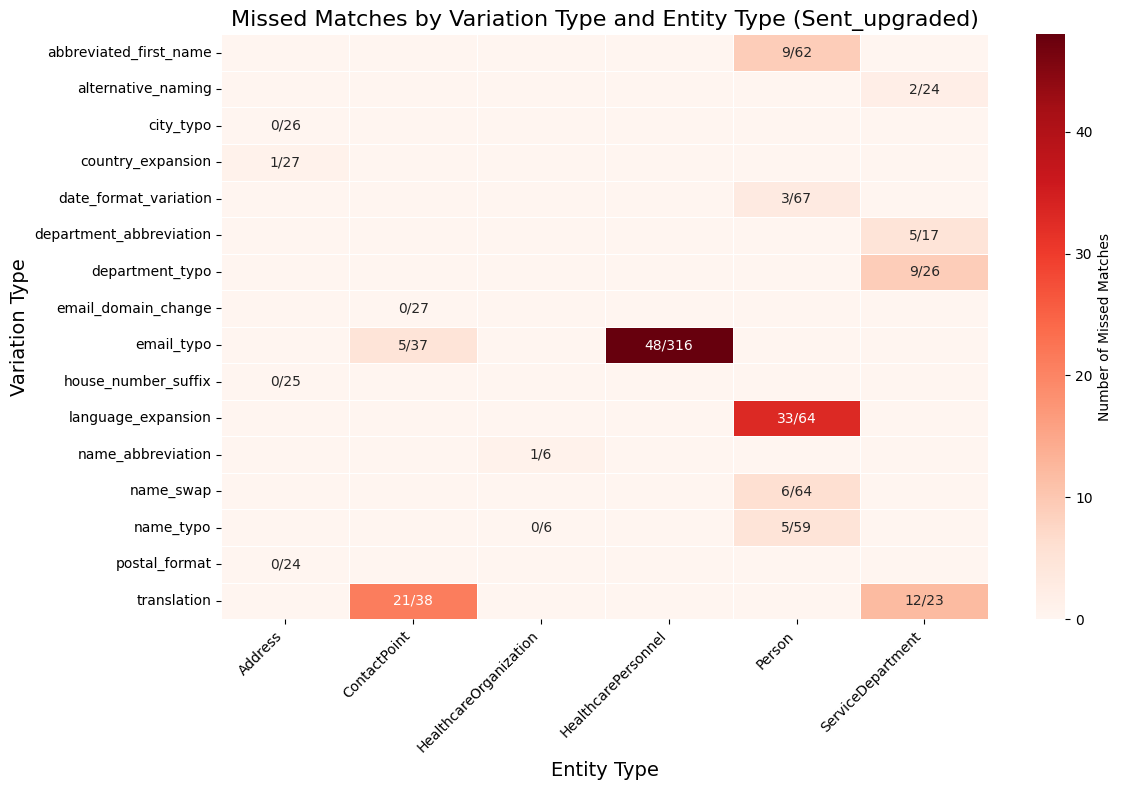

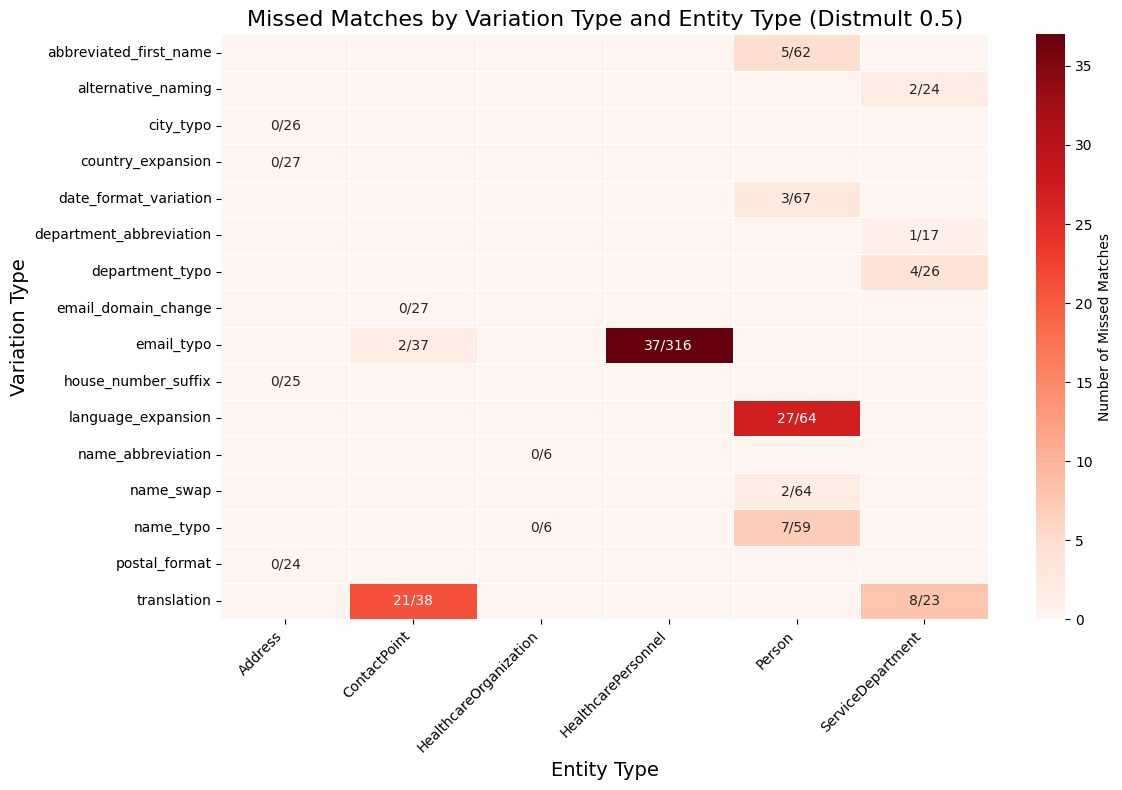

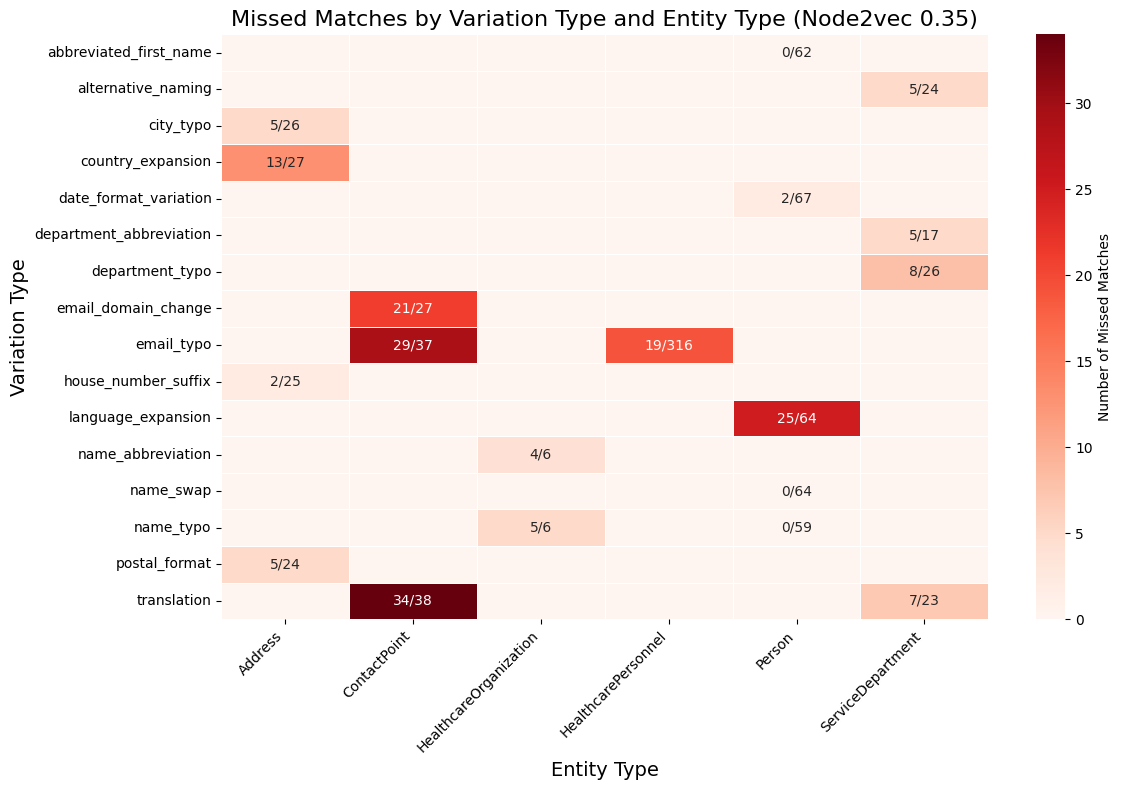

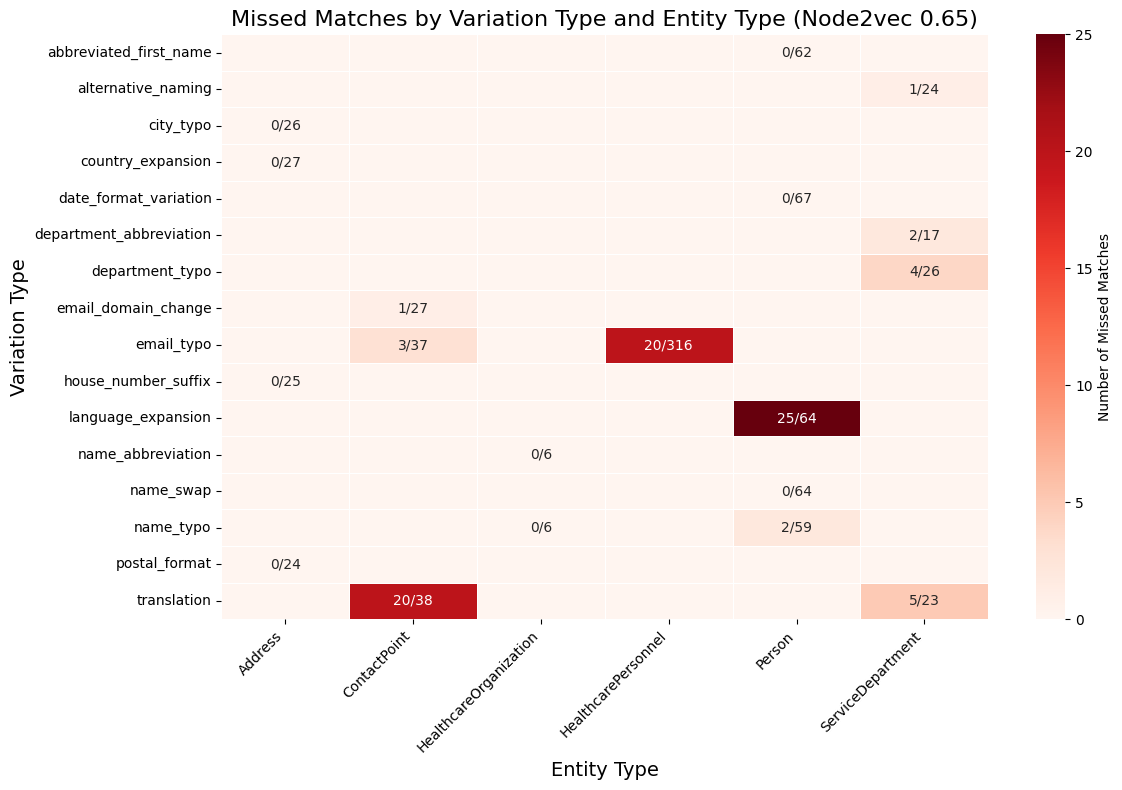

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example mapping from variation type to noise level (from your LaTeX table)
noise_mapping = {
    'house_number_suffix': 'Simple',
    'city_typo': 'Simple',
    'postal_format': 'Simple',
    'country_expansion': 'Complex',
    'name_swap': 'Simple',
    'abbreviated_first_name': 'Simple',
    'name_typo': 'Simple',
    'date_format_variation': 'Simple',
    'language_expansion': 'Complex',
    'name_abbreviation': 'Complex',
    'name_typo': 'Simple',
    'department_abbreviation': 'Complex',
    'alternative_naming': 'Complex',
    'translation': 'Complex',
    'department_typo': 'Simple',
    'email_typo': 'Simple',
    'email_domain_change': 'Simple'
}

# Loop over all models and plot missed matches heatmap for each
for model_name, missing_rows in missing_rows_by_model.items():
    
# Add noise level column
    missed_counts['NoiseLevel'] = missed_counts.index.map(noise_mapping)
    missed_counts = missing_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    # Ensure both have the same index and columns
    all_index = total_counts.index.union(missed_counts.index)
    all_columns = total_counts.columns.union(missed_counts.columns)
    missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
    total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

    # Create annotation matrix like "missed/total"
    annot = missed_counts.astype(str) + "/" + total_counts.astype(str)
    annot = annot.where(total_counts != 0, "")

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        missed_counts,
        annot=annot,
        fmt="",
        cmap="Reds",
        linewidths=.5,
        cbar_kws={'label': 'Number of Missed Matches'}
    )
    plt.title(f"Missed Matches by Variation Type and Entity Type ({model_name})", fontsize=16)
    plt.ylabel("Variation Type", fontsize=14)
    plt.xlabel("Entity Type", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

C:\Users\Timo\AppData\Local\Temp\ipykernel_7500\2521604177.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


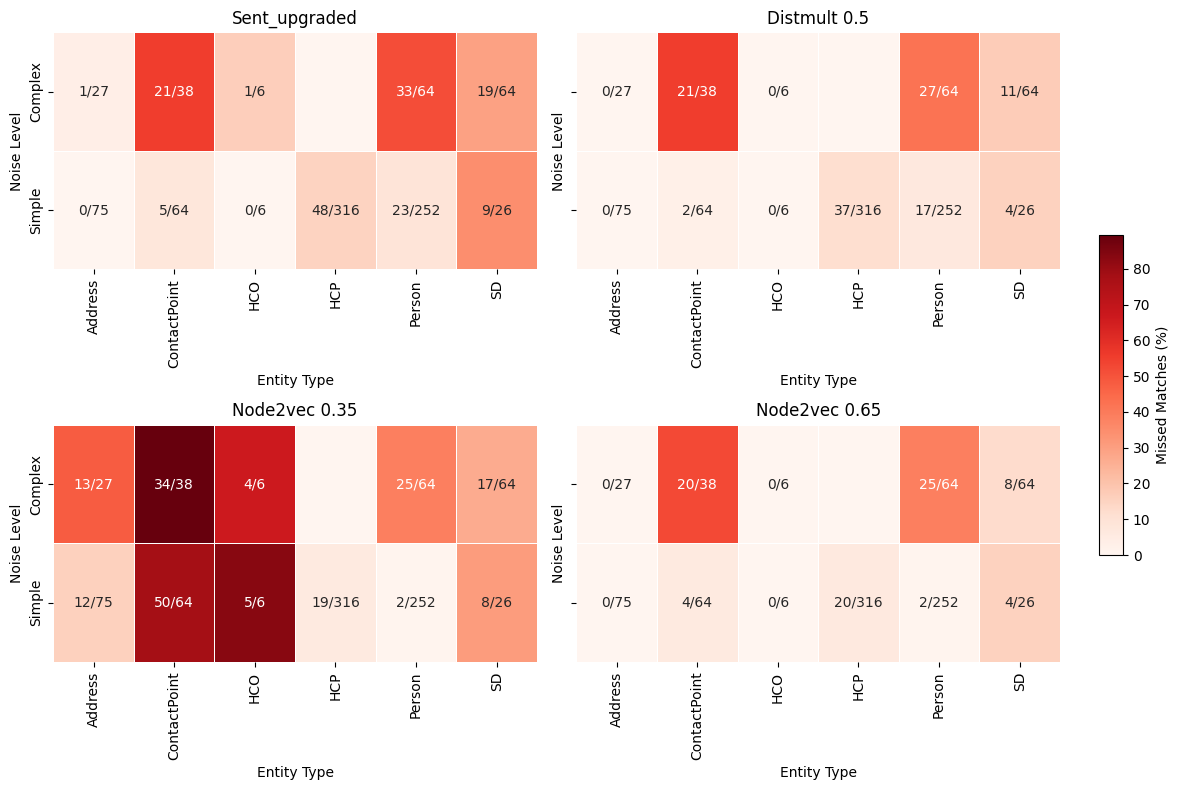

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---- Precompute missed & total counts aggregated by NoiseLevel ----
model_matrices = {}
annotations = {}
percent_matrices = {}
global_max_pct = 0
entity_types = set()

for model_name, missing_rows in missing_rows_by_model.items():
    missed_counts = missing_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    all_index = total_counts.index.union(missed_counts.index)
    all_columns = total_counts.columns.union(missed_counts.columns)
    missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
    total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

    noise_levels = all_index.map(lambda x: noise_mapping.get(x, "Unknown"))
    missed_counts["NoiseLevel"] = noise_levels
    total_counts["NoiseLevel"] = noise_levels

    # Aggregate by NoiseLevel (Simple vs Complex)
    missed_by_noise = missed_counts.groupby("NoiseLevel").sum()
    total_by_noise = total_counts.groupby("NoiseLevel").sum()

    # Compute percentages (avoid division by 0)
    pct_matrix = (missed_by_noise / total_by_noise.replace(0, np.nan)) * 100
    pct_matrix = pct_matrix.fillna(0)

    # Annotations (missed/total)
    annot = missed_by_noise.astype(str) + "/" + total_by_noise.astype(str)
    annot = annot.where(total_by_noise != 0, "")

    model_matrices[model_name] = missed_by_noise
    annotations[model_name] = annot
    percent_matrices[model_name] = pct_matrix

    global_max_pct = max(global_max_pct, pct_matrix.values.max())
    entity_types.update(missed_by_noise.columns)

entity_types = sorted(entity_types)
# Mapping for shorter names
entity_rename = {
    "HealthcareOrganization": "HCO",
    "HealthcarePersonnel": "HCP",
    "ServiceDepartment": "SD"
}

# Apply renaming to all entity type columns for consistency
entity_types = [entity_rename.get(e, e) for e in entity_types]

# Also update columns in each matrix
for model_name in percent_matrices.keys():
    percent_matrices[model_name].columns = [entity_rename.get(e, e) for e in percent_matrices[model_name].columns]
    annotations[model_name].columns = [entity_rename.get(e, e) for e in annotations[model_name].columns]

# ---- Subplot grid (2x2) ----
n_models = len(model_matrices)
ncols = 2
nrows = int(np.ceil(n_models / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey=True)
axes = axes.flatten()

# ---- Plot heatmaps (percent for color, counts for annotation) ----
for ax, (model_name, pct_matrix) in zip(axes, percent_matrices.items()):
    pct_matrix = pct_matrix.reindex(columns=entity_types)
    annot = annotations[model_name].reindex(columns=entity_types)

    sns.heatmap(
        pct_matrix,
        annot=annot,
        fmt="",
        cmap="Reds",
        vmin=0,
        vmax=global_max_pct,  # consistent color scale (percentage)
        linewidths=0.5,
        cbar=False,
        ax=ax
    )
    ax.set_title(model_name, fontsize=12)
    ax.set_xlabel("Entity Type")
    ax.set_ylabel("Noise Level")

# Hide extra subplots if fewer than nrows*ncols
for i in range(len(model_matrices), len(axes)):
    axes[i].axis('off')

# ---- Shared colorbar (percentage) ----
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
norm = plt.Normalize(vmin=0, vmax=global_max_pct)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label="Missed Matches (%)")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


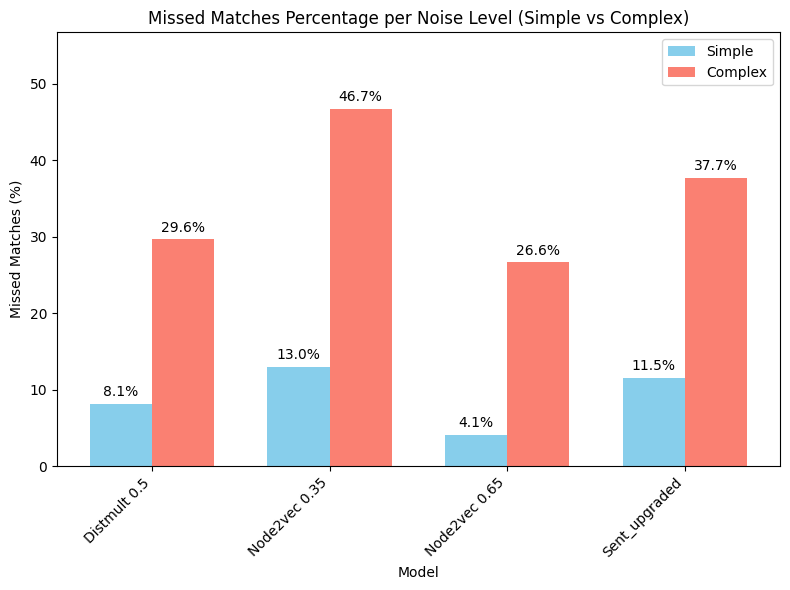

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Prepare empty list for summary
summary_data = []

for model_name, missing_rows in missing_rows_by_model.items():
    # --- Counts per variation type ---
    missed_counts = missing_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    # Ensure alignment
    all_index = total_counts.index.union(missed_counts.index)
    all_columns = total_counts.columns.union(missed_counts.columns)
    missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
    total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

    # Map variation types to noise level
    noise_levels = all_index.map(noise_mapping)
    missed_counts['NoiseLevel'] = noise_levels
    total_counts['NoiseLevel'] = noise_levels

    # Aggregate by noise level
    missed_by_noise = missed_counts.groupby('NoiseLevel').sum().drop(columns=['NoiseLevel'], errors='ignore')
    total_by_noise = total_counts.groupby('NoiseLevel').sum().drop(columns=['NoiseLevel'], errors='ignore')

    # Compute missed percentage
    for noise_level in missed_by_noise.index:
        missed = missed_by_noise.loc[noise_level].sum()
        total = total_by_noise.loc[noise_level].sum()
        pct = (missed / total * 100) if total > 0 else 0
        summary_data.append((model_name, noise_level, pct))

# Convert summary to DataFrame
summary_df = pd.DataFrame(summary_data, columns=["Model", "NoiseLevel", "MissedPct"])

# Pivot for grouped bar chart
pivot_df = summary_df.pivot(index="Model", columns="NoiseLevel", values="MissedPct").fillna(0)

# --- Plot grouped bar chart ---
x = np.arange(len(pivot_df.index))  # Model positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, pivot_df["Simple"], width, label="Simple", color="skyblue")
ax.bar(x + width/2, pivot_df["Complex"], width, label="Complex", color="salmon")

# Annotate values
for idx, val in enumerate(pivot_df["Simple"]):
    ax.text(idx - width/2, val + 1, f"{val:.1f}%", ha='center')
for idx, val in enumerate(pivot_df["Complex"]):
    ax.text(idx + width/2, val + 1, f"{val:.1f}%", ha='center')

# Labels & Title
ax.set_ylabel("Missed Matches (%)")
ax.set_xlabel("Model")
ax.set_title("Missed Matches Percentage per Noise Level (Simple vs Complex)")
ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index, rotation=45, ha="right")
ax.set_ylim(0, max(pivot_df.max()) + 10)
ax.legend()

plt.tight_layout()
plt.show()


In [25]:

# Create set of predicted pairs for fast lookup
predicted_pairs_set = set(pair_tuples)

# Create set of golden standard pairs (order-agnostic)
golden_pairs_set = set(
    tuple(sorted([row['original_id'], row['duplicate_id']]))
    for _, row in golden_standard.iterrows()
)

# Find missing pairs: those in golden_standard but not in predictions
missing_pairs = golden_pairs_set - predicted_pairs_set

# Optionally, get the rows from golden_standard corresponding to missing pairs
missing_rows = golden_standard[
    golden_standard.apply(
        lambda row: tuple(sorted([row['original_id'], row['duplicate_id']])) in missing_pairs,
        axis=1
    )
]

print(f"Number of missing golden_standard pairs: {len(missing_rows)}")
missing_rows

Number of missing golden_standard pairs: 83


,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value
116,bf7b6b3c-b1ca-41c3-8061-d029cb1d6d78,fd85d57d-1847-4560-90b7-8c153c43f9dd,ServiceDepartment,department_typo,serviceDepartmentName,Geriatric,Geiatric
126,6689ef79-f8c3-4461-bc15-b016487eb3df,a56e3fcc-d5c5-4f3a-8e10-a9dea407e939,ServiceDepartment,department_typo,serviceDepartmentName,Pediatric,Pldiatric
128,827254df-3830-4e4b-83d4-540a526aea43,80e93367-96cf-438d-891a-f6d47d1a2e42,ServiceDepartment,translation,serviceDepartmentName,Renal,Nier
131,9505de76-3ae0-4936-8170-b9484f130b23,8b769843-47a5-48e1-97e2-db4dd5e383a2,ServiceDepartment,translation,serviceDepartmentName,Nursing,Verzorging
134,3a94f14b-0830-4ee6-9a9c-1d73f173d2fe,b0563e9c-5b52-472d-bcc5-6d2fead82159,ServiceDepartment,alternative_naming,serviceDepartmentName,Optometric,Vision Care Center
...,...,...,...,...,...,...,...
910,799c82ee-f742-453b-a7a1-28de18310104,044ffa08-ce4d-4371-9951-07cbd3935bf7,ContactPoint,translation,contactType,information,teave
911,b0ca76f7-17f9-4524-8332-ed33bba6e752,bc0e7311-0f1b-4d24-acb9-ca7b91ba5b96,ContactPoint,translation,contactType,referrals,suunamine
915,84ddf869-b816-4f1a-9677-013ba8e19b83,1d3976f9-6b44-49dc-ae74-13f04b65e378,ContactPoint,translation,contactType,emergency,hÃ¤daolukord
923,fae3fcee-7636-4fd9-8376-ffa876fe579f,644064d5-1f21-49b4-8748-66303f5b02e8,ContactPoint,email_typo,email,PerezBecker@healthcare.org,PerzeBecker@healthcare.org


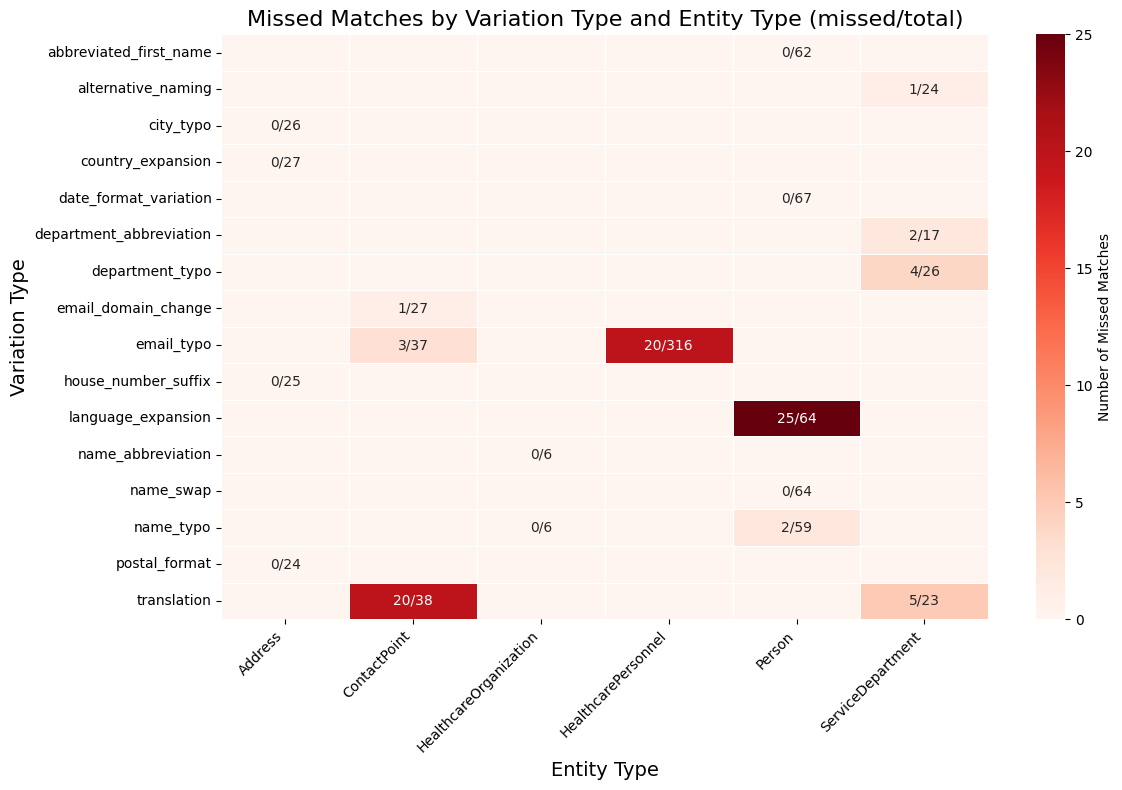

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate missed and total counts
missed_counts = missing_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)


# Ensure both have the same index and columns
all_index = total_counts.index.union(missed_counts.index)
all_columns = total_counts.columns.union(missed_counts.columns)
missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

# Create annotation matrix like "missed/total"
annot = missed_counts.astype(str) + "/" + total_counts.astype(str)
# Replace "0/0" with empty string for clarity
annot = annot.where(total_counts != 0, "")

plt.figure(figsize=(12, 8))
sns.heatmap(
    missed_counts, 
    annot=annot, 
    fmt="", 
    cmap="Reds", 
    linewidths=.5, 
    cbar_kws={'label': 'Number of Missed Matches'}
)
plt.title("Matches missed by Variation Type and Entity Type (missed/total)", fontsize=16)
plt.ylabel("Variation Type", fontsize=14)
plt.xlabel("Entity Type", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example mapping from variation type to noise level (from your LaTeX table)
noise_mapping = {
    'house_number_suffix': 'Simple',
    'city_typo': 'Simple',
    'postal_format': 'Simple',
    'country_expansion': 'Complex',
    'name_swap': 'Simple',
    'abbreviated_first_name': 'Simple',
    'name_typo': 'Simple',
    'date_format_variation': 'Simple',
    'language_expansion': 'Complex',
    'name_abbreviation': 'Complex',
    'name_typo': 'Simple',
    'department_abbreviation': 'Complex',
    'alternative_naming': 'Complex',
    'translation': 'Complex',
    'department_typo': 'Simple',
    'email_typo': 'Simple',
    'email_domain_change': 'Simple'
}

# Add noise level column
missed_counts['NoiseLevel'] = missed_counts.index.map(noise_mapping)

# Sort by noise level
missed_counts = missed_counts.sort_values(by=['NoiseLevel', missed_counts.index.name])
total_counts = total_counts.reindex(index=missed_counts.index)

# Drop helper column after sorting
noise_levels = missed_counts['NoiseLevel']
missed_counts = missed_counts.drop(columns='NoiseLevel')

# Compute annotations
annot = missed_counts.astype(str) + "/" + total_counts.astype(str)
annot = annot.where(total_counts != 0, "")

# ---- Compute overall percentages per Noise Level ----
summary = pd.DataFrame({
    'missed': missed_counts.sum(axis=1),
    'total': total_counts.sum(axis=1),
    'NoiseLevel': noise_levels
})
group_summary = summary.groupby('NoiseLevel').sum()
group_summary['missed_pct'] = (group_summary['missed'] / group_summary['total']) * 100

# ---- Plot heatmap ----
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    missed_counts, 
    annot=annot, 
    fmt="", 
    cmap="Reds", 
    linewidths=.5, 
    cbar_kws={'label': 'Number of Missed Matches'}
)

# Add separator between Simple and Complex
simple_count = (noise_levels == 'Complex').sum()
ax.hlines(simple_count, *ax.get_xlim(), colors='black', linewidth=2)

plt.title("Missed Matches by Variation Type Simple(lower) vs. Complex(upper)", fontsize=16)
plt.ylabel("Variation Type", fontsize=14)
plt.xlabel("Entity Type", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("=== Percentage Missed by Noise Level ===")
print(group_summary[['missed_pct']])


TypeError: unsupported operand type(s) for +: 'int' and 'str'

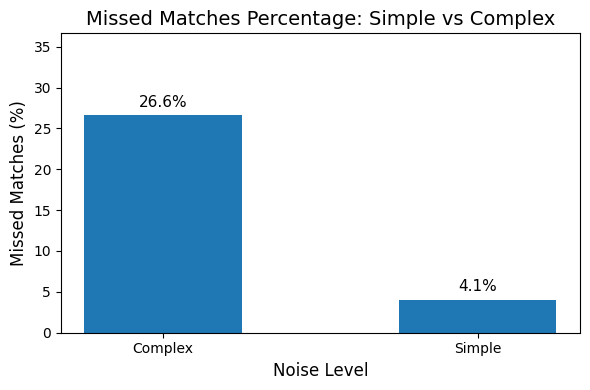

In [33]:
import matplotlib.pyplot as plt

# ---- Bar Chart of Missed Percentage (Simple vs Complex) ----
plt.figure(figsize=(6, 4))
plt.bar(group_summary.index, group_summary['missed_pct'], width=0.5)

# Add labels and title
plt.ylabel("Missed Matches (%)", fontsize=12)
plt.xlabel("Noise Level", fontsize=12)
plt.title("Missed Matches Percentage: Simple vs Complex", fontsize=14)

# Annotate values on top of bars
for idx, val in enumerate(group_summary['missed_pct']):
    plt.text(idx, val + 1, f"{val:.1f}%", ha='center', fontsize=11)

plt.ylim(0, max(group_summary['missed_pct']) + 10)
plt.tight_layout()
plt.show()
